# **Yelp Data analytics**

I did a comprehensive analysis on  Yelp dataset containing thousands of businesses across the United States, focusing on three key service categories: "Delivery","Plumbing", and "Air Conditioning & Heating".Using PySpark for scalable data processing, I cleaned and standardized the dataset, tackling challenges like Duplicate and missing values.Did some EDA as well to see how the data is distributed


I discovered intriguing regional variations—certain states consistently outperformed others in service quality, while some cities showed surprising gaps between customer demand and satisfaction levels. The correlation between review volume and ratings revealed interesting customer behavior patterns that challenge conventional wisdom.

This project showcases how big data analytics can transform business decision-making, turning scattered customer feedback into actionable market intelligence. The insights range from identifying high-performing business models to revealing untapped market potential across America's diverse economic landscape

In [1]:
# initializing spark session
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Yelp analysis") \
    .master("local[*]") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/14 18:57:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
DF = spark.read.format("csv").option("header", True).option("inferSchema", True).load("/kaggle/input/yelp-dataset-contains-1-million-rows/yelp_database.csv")

**Selecting only columns in Needed**

In [3]:
df = DF.select(['ID','Phone','Organization','OLF','Rating','NumberReview','Category','Country','State','City'])

# Exploratory Data analysis

In [4]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Phone: string (nullable = true)
 |-- Organization: string (nullable = true)
 |-- OLF: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- NumberReview: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- State: string (nullable = true)
 |-- City: string (nullable = true)



In [5]:
df.describe().show(vertical=True)

25/07/14 18:57:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0-------------------------------
 summary      | count                   
 ID           | 1000000                 
 Phone        | 1000000                 
 Organization | 999531                  
 OLF          | 38110                   
 Rating       | 1000000                 
 NumberReview | 1000000                 
 Category     | 1000000                 
 Country      | 1000000                 
 State        | 998942                  
 City         | 999531                  
-RECORD 1-------------------------------
 summary      | mean                    
 ID           | 500000.5                
 Phone        | 1.603186562275147...    
 Organization | 867.0540540540541       
 OLF          | NULL                    
 Rating       | 2.784374                
 NumberReview | 56.685617               
 Category     | NULL                    
 Country      | NULL                    
 State        | 35.333333333333336      
 City         | NULL                    
-RECORD 2-------

In [6]:
# to check the coutnof null values in each column
for col in df.columns:
    print(col, '\t', 'with null values: ', df.filter(df[col].isNull()).count())

ID 	 with null values:  0


Phone 	 with null values:  0


Organization 	 with null values:  469


OLF 	 with null values:  961890


Rating 	 with null values:  0


NumberReview 	 with null values:  0


Category 	 with null values:  0


Country 	 with null values:  0


State 	 with null values:  1058


City 	 with null values:  469


# Data Cleaning

In [7]:
'''since organization with null value does'nt make any sense,dropping null values'''

df = df.na.drop(how='all',subset=['Organization'])

In [8]:
df = df.repartition(150,'State')
print(df.rdd.getNumPartitions)

<bound method RDD.getNumPartitions of MapPartitionsRDD[95] at javaToPython at NativeMethodAccessorImpl.java:0>


In [9]:
from pyspark.sql.functions import when,lit,character_length,substring,col
'''Checking for any duplicates'''
df.groupBy(['Organization','Category','State','City','Phone','OLF'])\
.count()\
.sort(col('count').desc())\
.show(100)

+--------------------+--------------------+-----+-------------------+-----------+----+-----+
|        Organization|            Category|State|               City|      Phone| OLF|count|
+--------------------+--------------------+-----+-------------------+-----------+----+-----+
|          RJ Morello|            Plumbing|   MA|             Woburn|17812817545| INC|  119|
|      Quality Deluxe|            Plumbing|   MA|           Brockton|15083152109|NULL|  100|
|Clear Water Plumb...|            Plumbing|   RI|   North Smithfield|14019996112|NULL|   95|
|Reliable Well & Pump|            Plumbing|   MA|          Tewksbury|19789679060|NULL|   89|
|Cadorette Plumbin...|            Plumbing|   RI|   North Smithfield|14014803938|NULL|   89|
|Superior Plumbing...|            Plumbing|   NY|         Ozone Park|17189258282|NULL|   81|
|Mass State Kitche...|            Plumbing|   MA|             Bourne|15088881812|NULL|   79|
|       Hoss Plumbing|            Plumbing|   CT|            Bethany|1

Yikes there are lot of duplicates!!

In [10]:
# Organization has all number rows so filtering them
df = df.filter(~df['Organization'].rlike('^-?\\d+(\\.\\d+)?$'))

# Dropping all the duplicates to reduce size and get cleanier data
df = df.dropDuplicates(['Phone','Organization','Category','State','City','OLF'])

In [11]:
df.describe('Organization').show()
df.describe('State').show()

+-------+-----------------------+
|summary|           Organization|
+-------+-----------------------+
|  count|                 316399|
|   mean|                   NULL|
| stddev|                   NULL|
|    min|                # 1 Wok|
|    max|尚串Meet PG火锅串串烧烤|
+-------+-----------------------+



+-------+------------------+
|summary|             State|
+-------+------------------+
|  count|            316217|
|   mean|              29.0|
| stddev|26.870057685088806|
|    min|                10|
|    max|               YOR|
+-------+------------------+



In [12]:
df.select('State').distinct().collect()

[Row(State='AZ'),
 Row(State='WV'),
 Row(State='10'),
 Row(State='XGM'),
 Row(State='ID'),
 Row(State='Jackson'),
 Row(State='Kells'),
 Row(State='NE'),
 Row(State='SD'),
 Row(State='SON'),
 Row(State='BST'),
 Row(State='DC'),
 Row(State='VT'),
 Row(State='Apple'),
 Row(State='ABE'),
 Row(State='Knighton'),
 Row(State='CHW'),
 Row(State='SWA'),
 Row(State='MO'),
 Row(State='48'),
 Row(State='BCN'),
 Row(State='ABD'),
 Row(State='STS'),
 Row(State='SCB'),
 Row(State='WOR'),
 Row(State='G'),
 Row(State='NFK'),
 Row(State='WA'),
 Row(State='CHH'),
 Row(State='BRC'),
 Row(State='Spokane'),
 Row(State=None),
 Row(State='CAM'),
 Row(State='Juárez'),
 Row(State='NSW'),
 Row(State='IN'),
 Row(State='DBY'),
 Row(State='TX'),
 Row(State='NH'),
 Row(State='KEN'),
 Row(State='SC'),
 Row(State='Minneapolis'),
 Row(State='OH'),
 Row(State='LA'),
 Row(State='Westport'),
 Row(State='MN'),
 Row(State='PTE'),
 Row(State='MT'),
 Row(State='Mexicali'),
 Row(State='FL'),
 Row(State='DE'),
 Row(State='Gray'

'State' column values have differing lengths and is of only number fixing those and droping columns which have null values

In [13]:
#check columns with length greater than 3 and shrinking them

df = df.withColumn('State', when(character_length(df['State'])>3,
substring(df['State'],0,3)).otherwise(df['State']))

# rename the columns which have numbers in state column
df = df.withColumn('State', when(df['State'].rlike('^-?\\d+(\\.\\d+)?$'),
'Unknown').otherwise(df['State']))

#Drop where columns are null or none
df = df.na.drop(how='all',subset=['State'])

In [14]:
df.describe().show(vertical=True)

-RECORD 0-------------------------------
 summary      | count                   
 ID           | 316217                  
 Phone        | 316217                  
 Organization | 316217                  
 OLF          | 22157                   
 Rating       | 316217                  
 NumberReview | 316217                  
 Category     | 316217                  
 Country      | 316217                  
 State        | 316217                  
 City         | 316217                  
-RECORD 1-------------------------------
 summary      | mean                    
 ID           | 449900.6052584143       
 Phone        | 1.600293109933321E10    
 Organization | NULL                    
 OLF          | NULL                    
 Rating       | 2.8576452246400414      
 NumberReview | 59.88422191090296       
 Category     | NULL                    
 Country      | NULL                    
 State        | NULL                    
 City         | NULL                    
-RECORD 2-------

Phone number is little wonky need to fix that

In [15]:
#df = df.withColumn('Phone',when(df['Phone'].rlike(r'^\d{10}$'),df['Phone']).otherwise("Invalid number"))

In [16]:
#Setting a flag for called 'New Place' to address the skewness#
df = df.withColumn('New Place', when((df['Rating']==0) & (df['NumberReview']<20),
True).otherwise(False)) 

In [17]:
#Adding a new column called visitor to simulate how the population is
from pyspark.sql.functions import rand,floor

df = df.withColumn('Number_of_Visitors',
                   when(df['NumberReview'].between(0,100),floor(rand() * 1000) + 1)
                   .when(df['NumberReview'].between(101,1000),floor(rand() * 10000) + 1)
                   .when(df['NumberReview'].between(1001,10000),floor(rand() * 100000) + 1)
                   .otherwise(floor(rand() * 1000000) + 1)
                  )

In [18]:
# not necessray but saving the file just incase
df = df.repartition(150,'State')
print(df.rdd.getNumPartitions)
df.write.mode("overwrite").json('/kaggle/working/savedFile/')

<bound method RDD.getNumPartitions of MapPartitionsRDD[163] at javaToPython at NativeMethodAccessorImpl.java:0>


# Data Analysis

Now That the Data is cleaned lets get started with the Analysis!!

In [19]:
#importing visulaiztion library
import matplotlib.pyplot as plt                                     
%matplotlib inline                                                  

In [20]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Phone: string (nullable = true)
 |-- Organization: string (nullable = true)
 |-- OLF: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- NumberReview: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- State: string (nullable = true)
 |-- City: string (nullable = true)
 |-- New Place: boolean (nullable = false)
 |-- Number_of_Visitors: long (nullable = true)



Plotting a histogram to see how the rating are distributed

In [21]:
df = df.where(df['New place']==False)

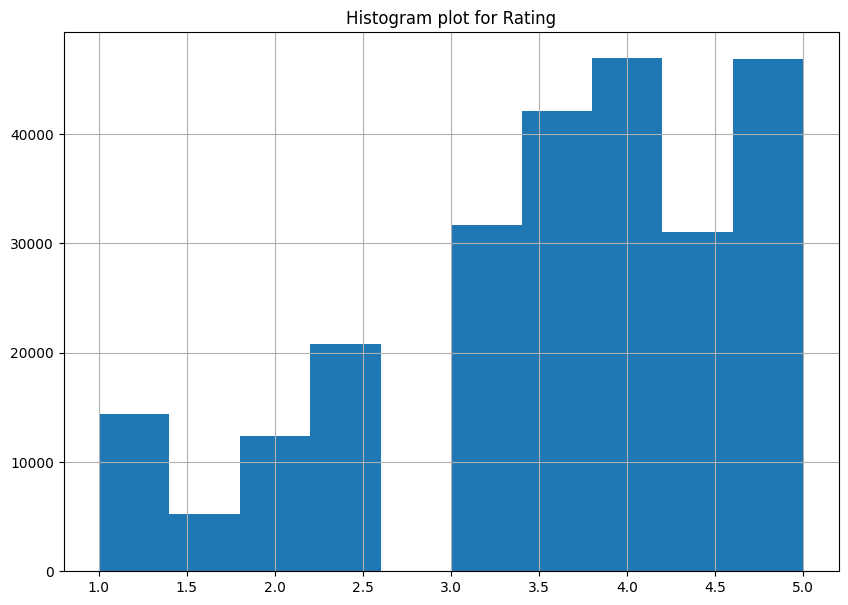

In [22]:
fig, ax = plt.subplots(figsize=(10, 7))
# PySpark DataFrame to Pandas
Histdf = df.select('Rating').filter(df['New Place']==False).toPandas()
Histdf['Rating'].hist(ax=ax)
plt.title("Histogram plot for Rating")
plt.show()

scatter plot for Rating and number

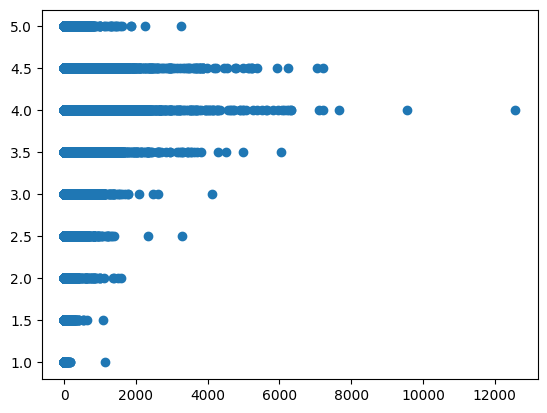

In [23]:
scatterdf = df.select(['Rating','NumberReview']).filter(df['New Place']==False).toPandas()
plt.scatter(scatterdf['NumberReview'],scatterdf['Rating'])
plt.show()

In [24]:
from pyspark.sql.functions import col, corr, count, avg, stddev, min, max
from pyspark.sql.types import DoubleType

# Calculate basic correlation between Rating and NumberReview
correlation_result = df.select(corr('Rating', 'NumberReview').alias('correlation_coefficient'))
correlation_result.show()

# Get descriptive statistics
stats = df.select(
    avg('Rating').alias('avg_rating'),
    avg('NumberReview').alias('avg_reviews'),
    stddev('Rating').alias('stddev_rating'),
    stddev('NumberReview').alias('stddev_reviews'),
    min('Rating').alias('min_rating'),
    max('Rating').alias('max_rating'),
    min('NumberReview').alias('min_reviews'),
    max('NumberReview').alias('max_reviews'),
    count('*').alias('total_businesses')
)
stats.show()

+-----------------------+
|correlation_coefficient|
+-----------------------+
|    0.08037585938161843|
+-----------------------+



+-----------------+-----------------+------------------+------------------+----------+----------+-----------+-----------+----------------+
|       avg_rating|      avg_reviews|     stddev_rating|    stddev_reviews|min_rating|max_rating|min_reviews|max_reviews|total_businesses|
+-----------------+-----------------+------------------+------------------+----------+----------+-----------+-----------+----------------+
|3.593214677673331|75.29866313562692|1.1161458105558557|200.21291175378008|       1.0|       5.0|          1|      12570|          251484|
+-----------------+-----------------+------------------+------------------+----------+----------+-----------+-----------+----------------+



# Basic Distribution Metrics
* Average rating by state,city
* Number of businesses per state,city

In [25]:
#Average Rating state,city wise, explains whether more reviews equals more rating
AvDF = df.groupby(['State','City']).agg({'Rating':'Avg','NumberReview':'Sum'})
AvDF.select(
    'City',
    'State',
    col('sum(NumberReview)').alias('total_Reviews'),
    col('avg(Rating)').alias('avg_rating')
).sort(col('total_Reviews').desc()).show()

+-------------+-----+-------------+------------------+
|         City|State|total_Reviews|        avg_rating|
+-------------+-----+-------------+------------------+
|  Los Angeles|   CA|       628774|3.9921259842519685|
|     New York|   NY|       509739| 3.876600102406554|
|San Francisco|   CA|       486670| 4.071700991609458|
|    San Diego|   CA|       432565| 4.064882943143813|
|    Las Vegas|   NV|       358683|3.8059561128526647|
|      Chicago|   IL|       354093| 3.761753183153771|
|      Seattle|   WA|       226405| 3.939064200217628|
|     San Jose|   CA|       198442| 4.022466039707419|
|       Austin|   TX|       174778| 3.857315598548972|
| Philadelphia|   PA|       165185|3.6580882352941178|
|           DC|   DC|       162588| 3.649032258064516|
|     Brooklyn|   NY|       155357|3.8714285714285714|
|      Houston|   TX|       153054|3.9088937093275486|
|       Boston|   MA|       145152| 3.674803149606299|
|      Phoenix|   AZ|       142142| 3.817524841915086|
|   Sacram

In [26]:
# Give the total counts of business in a city,so more options i guess
df.groupby(['State','City']).count().orderBy('count',ascending=False).show()

+-----+-------------+-----+
|State|         City|count|
+-----+-------------+-----+
|   CA|  Los Angeles| 2540|
|   IL|      Chicago| 2042|
|   NY|     New York| 1953|
|   NV|    Las Vegas| 1595|
|   PA| Philadelphia| 1496|
|   CA|    San Diego| 1495|
|   NY|     Brooklyn| 1400|
|   CA|San Francisco| 1311|
|   AZ|      Phoenix| 1107|
|   FL|        Miami| 1069|
|   CA|     San Jose|  957|
|   TX|  San Antonio|  944|
|   TX|      Houston|  922|
|   WA|      Seattle|  919|
|   CO|       Denver|  909|
|   GA|      Atlanta|  907|
|   FL| Jacksonville|  883|
|   FL|      Orlando|  881|
|   OR|     Portland|  879|
|   NC|    Charlotte|  865|
+-----+-------------+-----+
only showing top 20 rows



# Category-Based Analytics


* Average rating by category, review volume by category
* Most/least common business categories per region
* Which categories consistently get higher ratings

In [27]:
# Category wise average Rating and total reviews , which helps identify how categories perform and how popular they are
Catgory_Df = df.groupby(['Category']).agg({'Rating':'Avg','NumberReview':'Sum'})
Catgory_Df.select(
    col('Category'),
    col('sum(NumberReview)').alias('total_Reviews'),
    col('avg(Rating)').alias('avg_rating')
).sort(col('total_Reviews').desc()).show()

+--------------------+-------------+------------------+
|            Category|total_Reviews|        avg_rating|
+--------------------+-------------+------------------+
|            Delivery|     17668019|3.4614218230594274|
|            Plumbing|       726439| 3.829777290457103|
|Air Conditioning ...|       541951|3.7660614525139664|
+--------------------+-------------+------------------+



In [28]:
'''Most/least common business categories per state,help us identify which category is popular in a said state and how dominant they are'''
# each states business count category wise
category_distribution = df.groupBy('State', 'Category').count().withColumnRenamed('count', 'business_count')

# Get total businesses for each state
state_totals = df.groupBy('State').count().withColumnRenamed('count', 'total_businesses')

# joining the tables and calculating percentage
category_distribution.join(state_totals, 'State') \
    .withColumn('percentage', 
                (col('business_count') / col('total_businesses') * 100))\
    .sort('State').show()

+-----+--------------------+--------------+----------------+------------------+
|State|            Category|business_count|total_businesses|        percentage|
+-----+--------------------+--------------+----------------+------------------+
|   AK|Air Conditioning ...|           148|             584| 25.34246575342466|
|   AK|            Delivery|           301|             584| 51.54109589041096|
|   AK|            Plumbing|           135|             584|23.116438356164384|
|   AL|            Plumbing|           623|            3049|20.432928829124304|
|   AL|Air Conditioning ...|           833|            3049|27.320432928829124|
|   AL|            Delivery|          1593|            3049| 52.24663824204657|
|   AR|            Plumbing|           445|            1801|24.708495280399777|
|   AR|Air Conditioning ...|           489|            1801|27.151582454192113|
|   AR|            Delivery|           867|            1801| 48.13992226540811|
|   AZ|            Plumbing|          15

Which categories consistently get higher ratings

In [29]:
from pyspark.sql.functions import avg, stddev, count,log
#which business categories maintain high customer satisfaction across all catgories
df.groupBy('Category') \
    .agg(
        avg('Rating').alias('avg_rating'),
        stddev('Rating').alias('rating_stddev'),
        count('*').alias('business_count'),
        avg('NumberReview').alias('avg_reviews')
    ) \
    .withColumn('rating_consistency', 
                lit(1) - col('rating_stddev')) \
    .withColumn('quality_score',
                (col('avg_rating') * 0.5) + 
                (col('rating_consistency') * 0.3) + 
                (log(col('avg_reviews') + 1) * 0.2)) \
    .orderBy(col('quality_score').desc()).show()

+--------------------+------------------+------------------+--------------+------------------+--------------------+------------------+
|            Category|        avg_rating|     rating_stddev|business_count|       avg_reviews|  rating_consistency|     quality_score|
+--------------------+------------------+------------------+--------------+------------------+--------------------+------------------+
|            Delivery|3.4614218230594274|0.8768302237741828|        154323|114.48727020599651| 0.12316977622581715|2.7174939062416725|
|            Plumbing| 3.829777290457103|1.3885470184648339|         55633|13.057699566803876|-0.38854701846483386|2.3269585911987507|
|Air Conditioning ...|3.7660614525139664|1.3909912031885117|         41528|13.050255249470236|-0.39099120318851166|2.2942614778677926|
+--------------------+------------------+------------------+--------------+------------------+--------------------+------------------+



# Geographic Insights
* States with highest average ratings
* Top-performing cities within each state
* Rating variance across different regions

In [30]:
Rating_sum = df.groupby('State').sum('Rating').withColumnRenamed('sum(Rating)','Total_Rating')

#Displaying states with Hightest Average Rating
Rating_sum.join(state_totals,'State','inner')\
    .withColumn('State_Average',(col('Total_Rating'))/(col('total_businesses')))\
    .select('State','State_Average').orderBy('State_Average',ascending=False).show(10)

+-----+-------------+
|State|State_Average|
+-----+-------------+
|  XGM|          5.0|
|  Spo|          5.0|
|  Mex|          5.0|
|  XWM|          5.0|
|  CON|          5.0|
|  NLE|          5.0|
|  Gra|          5.0|
|  DBY|          5.0|
|  SCB|          5.0|
|  TAM|          4.8|
+-----+-------------+
only showing top 10 rows



In [31]:
"""#Most Revieved Business(This might be noth that necssary)
Review_Sum = df.groupby('State','Organization').sum('NumberReview').withColumnRenamed('sum(NumberReview)', 'Total_Review')

#State wise average Rating(State total from previous analysis)

Review_Sum.join(state_totals,'State','inner')\
    .withColumn('Review_Vol',(col('Total_Review')/(col('total_businesses'))))\
    .select('State','Organization','Review_Vol').show()"""

"#Most Revieved Business(This might be noth that necssary)\nReview_Sum = df.groupby('State','Organization').sum('NumberReview').withColumnRenamed('sum(NumberReview)', 'Total_Review')\n\n#State wise average Rating(State total from previous analysis)\n\nReview_Sum.join(state_totals,'State','inner')    .withColumn('Review_Vol',(col('Total_Review')/(col('total_businesses'))))    .select('State','Organization','Review_Vol').show()"

In [32]:
# top performing cities: ordering the cities based on how well they perfrorm,
# This helps identify cities that have both high-quality businesses and active customer engagement.
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number,desc

df = df.repartition(150,'State')
print(df.rdd.getNumPartitions)

CityDF = df.groupby(['City']).agg({'Rating':'Avg','NumberReview':'Sum','Organization':'count','Number_of_Visitors':'Sum'})

BusinessDensity = col('count(Organization)')/col('sum(Number_of_Visitors)')
CityDf = CityDF.withColumn('Performance',(col('avg(Rating)') * 0.8) + (col('sum(NumberReview)') * 0.5) + (BusinessDensity * 0.2))
#Using window Function to rank
order = Window.orderBy(desc("Performance"))
CityDf.withColumn("Performance_Index", row_number().over(order)).select(['City','Performance','Performance_Index']).show()

#need some more work


<bound method RDD.getNumPartitions of MapPartitionsRDD[317] at javaToPython at NativeMethodAccessorImpl.java:0>


25/07/14 19:00:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/14 19:00:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/14 19:00:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/14 19:00:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/14 19:00:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/14 19:00:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/07/14 1

+-------------+------------------+-----------------+
|         City|       Performance|Performance_Index|
+-------------+------------------+-----------------+
|  Los Angeles| 314390.1937449881|                1|
|     New York|254959.60157328178|                2|
|San Francisco|243338.25738838327|                3|
|    San Diego| 216288.2508387665|                4|
|    Las Vegas|179383.04443367402|                5|
|      Chicago|177049.50946446566|                6|
|      Seattle|113205.65129520444|                7|
|     San Jose| 99254.21591325967|                8|
|       Austin| 87457.56688207683|                9|
| Philadelphia| 82614.92438944602|               10|
|           DC| 81296.91927423625|               11|
|     Brooklyn| 77967.08904542531|               12|
|      Houston| 76548.12505846705|               13|
|       Boston|  72600.4429830689|               14|
|     Portland| 71601.19127380024|               15|
|      Phoenix|  71098.5564794282|            

* Regional patterns: Rating variance across different regions

In [33]:
#Coefficient of Variation
Regional_df = df.groupBy('State').agg(
    avg('Rating').alias('Rating_avg'),
    stddev('Rating').alias('Rating_stddev')
)

Regional_df.withColumn('Coeff',(col('Rating_stddev')/col('Rating_avg'))*100).show()

+-----+------------------+------------------+------------------+
|State|        Rating_avg|     Rating_stddev|             Coeff|
+-----+------------------+------------------+------------------+
|   AZ|3.7375837772813196|1.0504865074603429| 28.10603240108389|
|   WV|3.2825829383886256|1.2675126580467728| 38.61327137309064|
|  XGM|               5.0|              NULL|              NULL|
|   ID| 3.509684361549498|1.1719132481751549| 33.39084451622209|
|  For|               4.0|              NULL|              NULL|
|   NE| 3.404104979811575|1.2574585452460136| 36.93947609440696|
|   SD|3.2296686746987953|1.3792392634582693|42.705286590640746|
|  SON|             4.425|1.0671531237239031| 24.11645477342154|
|   DC| 3.649807938540333|0.8522011252849282|23.349204660499172|
|   VT|3.5018382352941178|1.2738486312585318|36.376569837513976|
|   MO|3.4283704572098475|1.2153612614928635|  35.4501147604094|
|  BCN|           3.88125|0.9783858768658885|25.208009709910172|
|  SCB|               5.0

# Business Quality Metrics
* Businesses with >4.5 rating and >100 reviews
* Categories or regions with consistently low ratings

In [34]:
# Businesses with >4.5 rating and >100 reviews help us identify percentage of business that are high performers
High_Performance_Businesses = df.filter(((df['Rating'])>=4.5) & ((df['NumberReview'])>=100))\
                                .groupby('State').count()

#Percentage per state
High_Performance_Businesses.join(state_totals, 'State') \
    .withColumn('percentage', 
                (col('count') / col('total_businesses') * 100))\
    .sort('percentage',ascending=False).show()

+-----+-----+----------------+------------------+
|State|count|total_businesses|        percentage|
+-----+-----+----------------+------------------+
|   NV|  320|            2796|11.444921316165951|
|   CA| 4210|           38848|10.837108731466227|
|   DC|   70|             781| 8.962868117797695|
|   HI|   98|            1234| 7.941653160453808|
|   AZ|  385|            5819|  6.61625708884688|
|   WA|  300|            4610| 6.507592190889371|
|   TX|  713|           12943| 5.508769218882794|
|   FL|  887|           16754| 5.294258087620866|
|   OR|  196|            3758| 5.215540180947312|
|   UT|   96|            2239| 4.287628405538187|
|   VA|  234|            5761| 4.061794827286929|
|   CO|  225|            5654|3.9794835514679874|
|   NY|  629|           16269|3.8662486938349003|
|   IL|  349|           10724| 3.254382693024991|
|   NM|   51|            1632|             3.125|
|   GA|  174|            5684| 3.061224489795918|
|   MD|  142|            4886| 2.906262791649611|


* Categories or regions with consistently low ratings:
        Helps with identifying each organizantions rating against its category's average in each state

In [35]:
#Average rating Per State's Category
State_Category_Group = df.groupby(['State','Category']).avg('Rating').withColumnRenamed('avg(Rating)','Avg_Rating')

Business = df.select(['Organization','Rating','State','Category'])

#performance compared to Category average
State_Category_Group.join(Business,['State','Category'],'inner')\
    .withColumn('Performance',((col('Rating')-col('Avg_Rating'))/(col('Avg_Rating')))*100)\
    .select(['Organization','State','Category','Rating',col('Avg_Rating').alias('State_Category_Avg'),'Performance'])\
    .sort('State',ascending=True)\
    .show(100,truncate=False)

# Looks good need somemore work

+----------------------------------------------+-----+--------------------------+------+------------------+-------------------+
|Organization                                  |State|Category                  |Rating|State_Category_Avg|Performance        |
+----------------------------------------------+-----+--------------------------+------+------------------+-------------------+
|Harri Plumbing & Heating                      |AK   |Plumbing                  |2.5   |3.248148148148148 |-23.03306727480045 |
|Circle Plumbing & Heating                     |AK   |Air Conditioning & Heating|1.5   |3.4763513513513513|-56.85131195335277 |
|Pleasants Plumbing & Heating                  |AK   |Plumbing                  |2.5   |3.248148148148148 |-23.03306727480045 |
|C & J Plumbing and Electric                   |AK   |Plumbing                  |3.5   |3.248148148148148 |7.753705815279366  |
|Alaska Plumbing & Heating                     |AK   |Plumbing                  |2.5   |3.24814814814814